In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt 

In [215]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1)

def extract_landmarks(frame):
    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Extract landmarks and flatten them into a single vector
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
            return landmarks
    return None

In [8]:
image = cv2.imread("1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [9]:
image.shape

(612, 612, 3)

In [10]:
landmarks = extract_landmarks(image)

In [11]:
landmarks.shape

(63,)

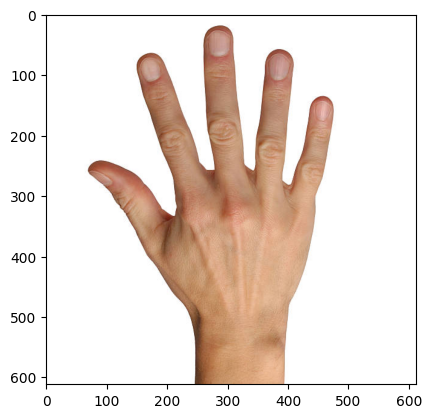

In [12]:
plt.imshow(image)

In [13]:
mp_drawing = mp.solutions.drawing_utils

In [14]:
results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


In [15]:
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

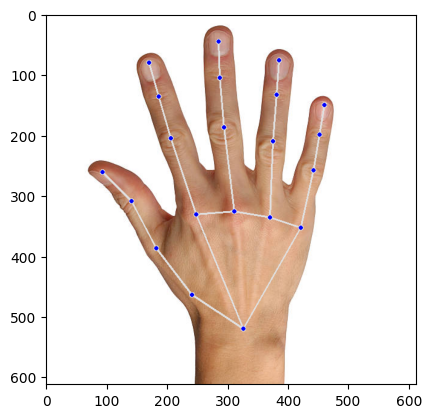

In [16]:
plt.imshow(image)

In [17]:
import torch
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
import h5py


class GestureDataset(Dataset):
    def __init__(self, hdf5_path, 
                 label_file, 
                 transform=None, 
                 sample_duration=60, 
                 include_no_gesture=True, 
                 label_all_gestures=False):
        """

        Parameter:
            frame_folders: Path to the directory where frame folders are stored.
            label_file: Path to the label .txt file.
            transform: Optional transforms to be applied on a sample.
            sample_duration: length of the video
            inlcude_no_gestures: Boolean to decide whether to include 'no gesture' class in the dataset.
            label_all_gestures: Boolean to decide whether to label all gestures as a single class.

        """
        self.hdf5_path = hdf5_path
        # self.frame_folders = frame_folders
        self.transform = transform
        self.include_no_gesture = include_no_gesture
        self.label_all_gestures = label_all_gestures
        self.sample_duration = sample_duration
        self.hdf5_file = h5py.File(self.hdf5_path, 'r')
        self.labels = self.parse_labels(label_file)

    # def __del__(self):
    #     self.hdf5_file.close()
    
    def parse_labels(self, label_file):
        """
        Parse the label file and return a structure containing
        the mappings of video name, start frame, end frame, label, label id and the number of frames.
        
        Parameters:
            label_file: .txt file that contains the labels
        
        Returns:
            list of tuples: (folder_name, start_frame, end_frame, label, label id, number of frames)
        """
        labels = []
        with open(label_file, 'r') as file:
            for line in file:
                folder_name, label, id, start, end, number_frames = line.split(",")
                if not self.include_no_gesture and label == 'D0X':
                    continue
                if self.label_all_gestures and label != 'D0X':
                    id = 0  # Assign a single ID for all gesture classes
                    label = 'Gesture'
                
                if self.label_all_gestures:
                    labels.append((folder_name, int(start), int(end), label, int(id), int(number_frames)))
                elif not self.include_no_gesture:
                    labels.append((folder_name, int(start), int(end), label, int(id) - 2, int(number_frames)))
                else:
                    labels.append((folder_name, int(start), int(end), label, int(id) - 1, int(number_frames)))
        return labels

    def _write_labels(self, path):
        with open(path, "w") as f: 
            for element in self.labels:
                s_to_wright = f"{element[0]} {element[1]} {element[2]} {element[3]} {element[4]} {element[5]}\n"
                f.write(s_to_wright)

    def get_labels(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        allows the dataset to be indexed, so that each call to dataset[idx] returns 
        the idx-th sample from the dataset.

        Parameters:
            idx: index of the datapoint
        
        Returns:
            a tuple of frames tensor and label id
        """
        folder_name, start, end, label, id, n_frames = self.labels[idx]
        frames = self.load_frames(folder_name, start, end)
        
        transformed_frames = []
        for frame in frames:
            if self.transform:
                # Apply transform to each frame
                transformed_frame = self.transform(frame)
                transformed_frames.append(transformed_frame)

        # Stack the frames back into a single tensor
        if self.transform:
            frames_tensor = torch.stack(transformed_frames)
            return frames_tensor, id, label
        return np.array(frames), id, label
    

    def load_frames(self, folder_name, start, end):
        """
        Load and return frames from the HDF5 file, between start and end frames.

        Parameters:
            folder_name: Name of the group in the HDF5 file corresponding to the video.
            start: Starting frame number.
            end: Ending frame number.
        """

        frames = []
        total_frames = end - start + 1
        step = max(1, total_frames // self.sample_duration)
        # Ensure the video group exists in the HDF5 file
        if folder_name in self.hdf5_file:
            video_group = self.hdf5_file[folder_name]

            for frame_idx in range(start, end + 1, step):  # Skip frames if more than fixed frame count
                # Construct the dataset name for each frame
                frame_dataset_name = f"{folder_name}_{folder_name}_{str(frame_idx).zfill(6)}"  # Assuming frame datasets are named by their indices

                if frame_dataset_name in video_group:
                    frame_data = video_group[frame_dataset_name]
                    frame = np.array(frame_data)
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    #frame = cv2.resize(frame, (128, 128))
                    frames.append(frame)
                    if len(frames) == self.sample_duration:
                        break

        # Apply padding to gestures with fewer frames than self.sample_duration
        while len(frames) < self.sample_duration and len(frames) > 0:
            frames.append(np.zeros_like(frames[0]))

        return frames

In [18]:
from torchvision import transforms

file = os.path.join("D:", "IPN_Hand","annotations-20231128T085307Z-001", "annotations", "Annot_TrainList.txt")
# frame_folders = os.path.join(".", "IPN_Hand", "frames")
hdf5_path = os.path.join("D:", "IPN_Hand", "hand_gestures.h5")
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
dataset = GestureDataset(hdf5_path, file, label_all_gestures=True, transform=transform)

In [139]:
video = dataset[7][0]

In [140]:
video = video.permute(0, 2, 3, 1)

In [141]:
video.shape

torch.Size([60, 240, 320, 3])

In [115]:
image = video[10]

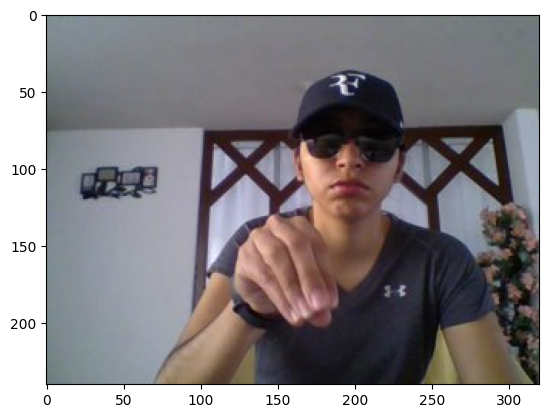

In [116]:
plt.imshow(image)

In [117]:
type(image)
image = image.numpy()
type(image)

numpy.ndarray

In [118]:
image = (image * 255).astype(np.uint8)

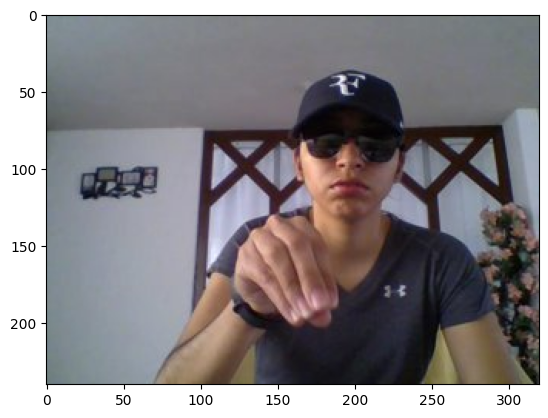

In [119]:
plt.imshow(image)

In [122]:
image.shape
image = np.ascontiguousarray(image, dtype=np.uint8)

In [ ]:
def process_image_for_landmarks(image):
    try:
        # Check if the input image is a NumPy array
        if not isinstance(image, np.ndarray):
            raise ValueError("Input image must be a NumPy array")
        
        # Check if the image has the correct data type (float32)
        if image.dtype != np.float32:
            raise ValueError("Input image must have data type float32")
        
        # Check if the image values are within the [0, 1] range
        if (image < 0).any() or (image > 1).any():
            raise ValueError("Input image values must be in the range [0, 1]")
        
        # Scale the image values to uint8 [0, 255] range
        image = (image * 255).astype(np.uint8)
        
        # Ensure the image is contiguous in memory
        image = np.ascontiguousarray(image, dtype=np.uint8)
        
        return image
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

In [138]:
def process_video_for_landmarks(video_frames):
    try:
        # Check if the input is a PyTorch tensor
        if not isinstance(video_frames, torch.Tensor):
            raise ValueError("Input must be a PyTorch tensor")
        
        # Check if the tensor has the correct dimensions (sequence, channels, height, width)
        if len(video_frames.shape) != 4:
            raise ValueError("Input tensor must have shape (sequence, channels, height, width)")
        
        # Check if the tensor data type is float32
        if video_frames.dtype != torch.float32:
            raise ValueError("Input tensor must have data type float32")
        
        # Check if the tensor values are within the [0, 1] range
        if (video_frames < 0).any() or (video_frames > 1).any():
            raise ValueError("Tensor values must be in the range [0, 1]")
        
        video_frames = video_frames.permute(0, 2, 3, 1)
        
        # Convert the tensor to a NumPy array and scale the values to uint8 [0, 255] range
        processed_video = (video_frames.numpy() * 255).astype(np.uint8)
        processed_video = np.ascontiguousarray(processed_video, dtype=np.uint8)
        return processed_video
    except Exception as e:
        print(f"Error processing video: {str(e)}")
        return None

In [142]:
video = process_video_for_landmarks(video)

In [200]:
video.shape

(60, 240, 320, 3)

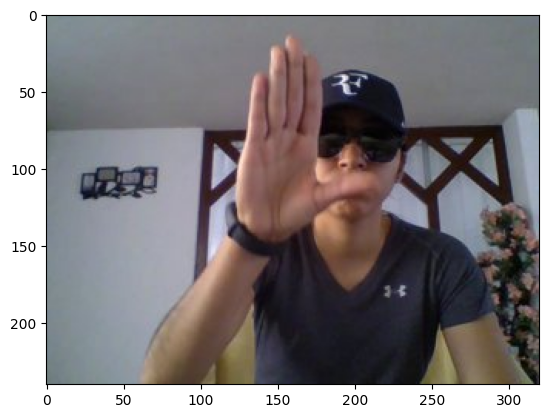

In [143]:
video[0].shape
plt.imshow(video[20])

In [147]:

def extract_landmarks(image):
    results = hands.process(image)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    return results

In [195]:
def extract_landmarks_video(video):
    out = []

    for image in video:
        results = hands.process(image)
        if results.multi_hand_landmarks:
            counter = 0
            for hand_landmarks in results.multi_hand_landmarks:
                landmarks = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
                out.append(landmarks)
                counter += 1
            print(counter)
                
        else:
            out.append(np.zeros((21, 3), np.uint8))
    
    return np.array(out)

In [231]:
def extract_landmarks_from_batch(batch_videos, hands):
    batch_size = batch_videos.shape[0]  # Number of videos in the batch
    num_frames = batch_videos.shape[1]  # Number of frames per video

    # Initialize an empty list to store landmarks for the entire batch
    batch_landmarks = []

    for video_idx in range(batch_size):
        video = batch_videos[video_idx]

        # Pre-allocate array for landmarks for this video
        video_landmarks = []
    
       
        for frame_idx in range(num_frames):
            frame = video[frame_idx]
            
            results = hands.process(frame)

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    landmarks = np.array([(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])
                    video_landmarks.append(landmarks)
                    
            else:
                video_landmarks.append(np.zeros((21, 3)))

        batch_landmarks.append(video_landmarks)

    return np.array(batch_landmarks).reshape(batch_size, num_frames, -1)

In [232]:
videos = np.expand_dims(video, axis=0)
v_landmarks = extract_landmarks_from_batch(videos, hands)
v_landmarks.shape

(1, 60, 63)

In [197]:
video.shape

(60, 240, 320, 3)

In [198]:
v_landmarks.shape

(60, 21, 3)

In [145]:
test_image = video[20]
extract_landmarks(test_image)

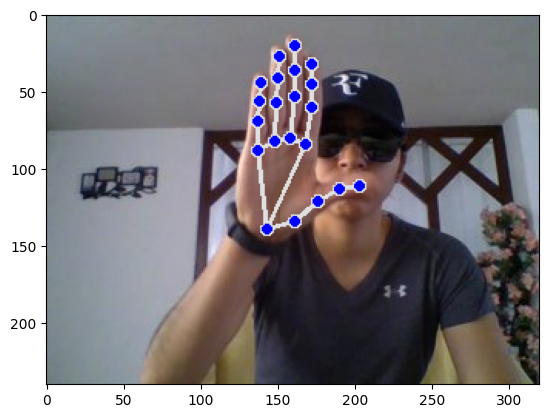

In [146]:
plt.imshow(test_image)

In [148]:
results = extract_landmarks(test_image)

In [159]:
for e in results.multi_hand_landmarks:
    landmarks = np.array([(lm.x, lm.y, lm.z) for lm in e.landmark])
    print(landmarks)

[[ 4.38069522e-01  5.77903271e-01  4.11786942e-07]
 [ 4.99558449e-01  5.48236907e-01 -2.35286169e-02]
 [ 5.48330724e-01  4.79104519e-01 -3.55732031e-02]
 [ 5.71199000e-01  4.24204946e-01 -4.72254567e-02]
 [ 5.82439542e-01  3.76299739e-01 -5.99798672e-02]
 [ 5.26971340e-01  3.52023929e-01 -1.80971716e-02]
 [ 5.42244971e-01  2.53187120e-01 -4.09179032e-02]
 [ 5.47956586e-01  1.89966917e-01 -6.14109263e-02]
 [ 5.52633882e-01  1.40418380e-01 -7.61536583e-02]
 [ 4.94998276e-01  3.39309752e-01 -2.26331241e-02]
 [ 5.05249262e-01  2.26402134e-01 -4.49528359e-02]
 [ 5.08275926e-01  1.54034838e-01 -6.91139102e-02]
 [ 5.11467814e-01  9.25266743e-02 -8.67600441e-02]
 [ 4.59403962e-01  3.44574988e-01 -3.05714067e-02]
 [ 4.65732157e-01  2.38991007e-01 -5.16813733e-02]
 [ 4.70157951e-01  1.70889199e-01 -7.08116516e-02]
 [ 4.73299235e-01  1.13497406e-01 -8.41986835e-02]
 [ 4.21290815e-01  3.64772379e-01 -4.04593460e-02]
 [ 4.23712075e-01  2.84404993e-01 -5.91308177e-02]
 [ 4.26961541e-01  2.31344059e-

In [160]:
len(results.multi_hand_landmarks)

1

In [161]:
landmarks = landmarks.flatten()

In [163]:
landmarks.shape

(63,)

In [164]:
63 / 3

21.0